In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import toolkit as kit
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import black_litterman as BL
import scipy.optimize as opt
import itertools


%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

# Import All Data

We will use data from 1993-07 to 2023-07. And any time before 1993-07 serves as the burnt-in set.

In [2]:
# Download historical data for S&P 500
sp500 = yf.download('^GSPC', start="1990-04-01", end="2023-08-01", progress=False)
sp500_monthly = sp500['Adj Close'].resample('M').ffill().pct_change().dropna()
sp500_monthly.index = pd.to_datetime(sp500_monthly.index, format="%Y%m").to_period('M')
sp500_monthly

Date
1990-05    0.091989
1990-06   -0.008886
1990-07   -0.005223
1990-08   -0.094314
1990-09   -0.051184
             ...   
2023-03    0.035052
2023-04    0.014642
2023-05    0.002482
2023-06    0.064727
2023-07    0.031139
Freq: M, Name: Adj Close, Length: 399, dtype: float64

In [3]:
views_simple = pd.read_csv('../Data/views_simple.csv', header=0, index_col=0)['1993-07':]
views_weighted = pd.read_csv('../Data/views_weighted.csv', header=0, index_col=0)['1993-07':]
decisions_simple = pd.read_csv('../Data/decisions_simple.csv', header=0, index_col=0)['1993-07':]
decisions_weighted = pd.read_csv('../Data/decisions_weighted.csv', header=0, index_col=0)['1993-07':]
confidence_simple = pd.read_csv('../Data/confidence_simple.csv', header=0, index_col=0)['1993-07':]
confidence_weighted = pd.read_csv('../Data/confidence_weighted.csv', header=0, index_col=0)['1993-07':]

In [4]:
ind30_rets = kit.get_ind_returns(weighting='vw', n_inds=30)
ind30_mcap = kit.get_ind_market_caps(30, weights=True)

In [5]:
rf = kit.get_risk_free_rate()['1990-03':'2023-06'] * 12
rf.tail()

,RF
2023-02,0.0408
2023-03,0.0432
2023-04,0.0420
2023-05,0.0432
2023-06,0.0480


## Brief Summary of Black-Litterman Model

For $N$ assets, and $K$ views: 

\begin{array}{ll}
w & \mbox{A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets} \\
\Sigma & \mbox{A Covariance Matrix ($N \times N$) of the Assets} \\
R_f & \mbox{The Risk Free Rate} \\
\delta & \mbox{The investor's Risk Aversion parameter}  \\
\tau & \mbox{A scalar indicating the uncertainty of the prior}\\
Q & \mbox{An $K \times 1$ Views matrix} \\
P & \mbox{A $K \times N$ ``Projection'' matrix} \\
\Omega & \mbox{Uncertainty Matrix}
\end{array}

#### The Master Formula

The first step of the procedure is a _reverse-optimization_ step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

Next, the posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMuOrig}
\mu^{BL} = [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}[(\tau\Sigma)^{-1} \pi + P \Omega^{-1} Q]
\end{equation}

\begin{equation}
\label{eq:blSigmaOrig}
\Sigma^{BL} = \Sigma + [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}
\end{equation}


## Model Implementation

We first find $\delta$: the risk-aversion parameter. Since the model is fully automatic, we use market-implied risk-aversion using SP500 as the hypothetical market portfolio. 

Market-implied risk aversion is a concept derived from mean-variance analysis, a fundamental part of Modern Portfolio Theory. This concept tries to quantify the level of risk aversion implied by market prices and returns. It's a way of understanding how much risk investors are willing to take on, given the expected returns of their investments.

### Formula

The formula to calculate market-implied risk aversion typically involves the Sharpe ratio of the market portfolio. The Sharpe ratio is defined as the excess return of the portfolio over the risk-free rate, divided by the standard deviation of the portfolio's excess return:

$$ \text{Sharpe Ratio} = \frac{R_m - R_f}{\sigma_m} $$

Where:
- $R_m$ is the return of the market portfolio.
- $R_f$ is the risk-free rate.
- $\sigma_m$ is the standard deviation of the market portfolio's return.

The market-implied risk aversion coefficient $\delta$ can be estimated using the Sharpe ratio:

$$\delta = \frac{R_m - R_f}{\sigma_m^2}$$

In [6]:
def market_implied_risk_aversion(market_ret, risk_free_rate, frequency=12):
    """
    Calculate the market-implied risk-aversion parameter (i.e market price of risk)
    based on market monthly returns.
    """
    annualized_var = market_ret.rolling(window=frequency).var().dropna() * frequency
    annualized_return = market_ret.rolling(window=frequency).mean().dropna() * frequency
    risk_free_rate = risk_free_rate.rolling(window=frequency).mean().dropna()
    return (annualized_return - risk_free_rate) / annualized_var

In [7]:
delta = market_implied_risk_aversion(sp500_monthly['1992-07':'2023-06'], rf['RF']['1992-07':'2023-06'], frequency=12)
delta.describe()

count    361.000000
mean      10.140161
std       18.171006
min      -12.821880
25%        0.055330
50%        5.692135
75%       14.769786
max      121.460412
dtype: float64

We observe the range of values of risk aversion coefficient is too wide.

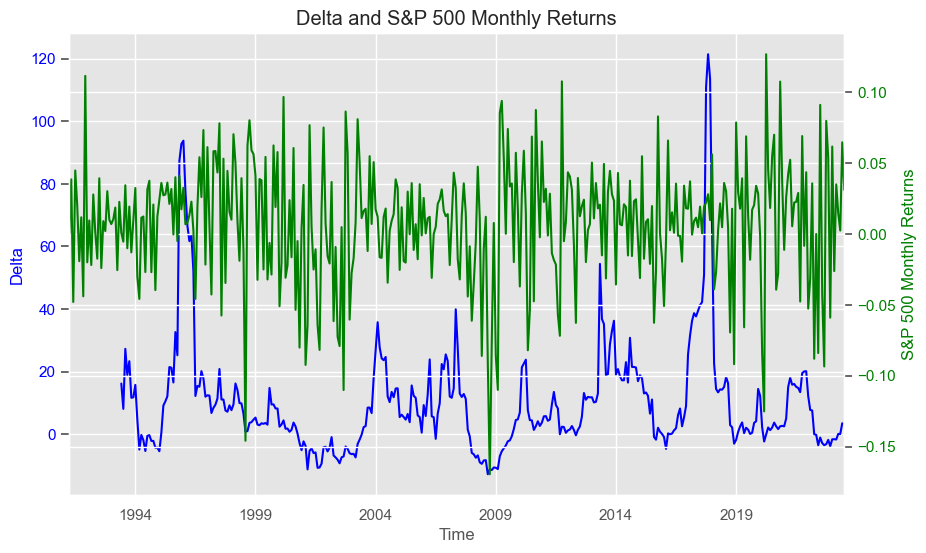

In [8]:
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'delta' on the left y-axis
delta.plot(ax=ax1, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Delta', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the second plot
ax2 = ax1.twinx()

# Plot 'sp500_monthly' on the right y-axis
sp500_monthly['1991-04':].plot(ax=ax2, color='green')
ax2.set_ylabel('S&P 500 Monthly Returns', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set the title
plt.title('Delta and S&P 500 Monthly Returns');

Refering to 'Risk Aversion at the Country Level ['https://files.stlouisfed.org/files/htdocs/wp/2014/2014-005.pdf']:

"Although there is a vast literature on measuring risk aversion, there is not yet a commonly accepted estimate. Probably the most commonly accepted measures of the coefficient of relative risk aversion lie between 1 and 3, but there is a wide range of estimates in the literature—from as low as 0.2 to 10 and higher."

We will try 2 sets of values, one keeping $\delta \in [1, 3]$ and another keeping $\delta \in [0.01, 10]$.

## Construct a Class for Each Single Period

Let's start from an example of a single period. We want to use data from 1992-07 to 1993-06 as training data to get the BL weight for the month of 1993-07.1993-07

In [9]:
def market_implied_risk_aversion(market_ret, risk_free_rate, frequency=12, adjustment=None):
    """
    Calculate the market-implied risk-aversion parameter (i.e market price of risk)
    based on market monthly returns.
    """
    annualized_var = market_ret.var() * frequency
    annualized_return = market_ret.mean() * frequency
    delta = (annualized_return - risk_free_rate) / annualized_var
    if adjustment is None:
        return delta
    elif delta > adjustment[1]: 
        delta = adjustment[1]
    elif delta < adjustment[0]:
        delta = adjustment[0]
    return delta

In [10]:
def market_implied_prior_returns(market_caps, risk_aversion, cov_matrix, risk_free_rate):
    """
    The neutral prior distribution is obtained by reverse engineering assuming 
    market or benchmark is the optimal portfolio. 
    
    Weights are taking from the begining of the rolling period.
    """
    # Pi is excess returns so must add risk_free_rate to get return.
    return (risk_aversion * cov_matrix@market_caps + risk_free_rate)

In [11]:
def update_P_Q(absolute_view):
    """
    Given a collection of absolute views, construct
    the appropriate views vector and picking matrix. 
    """
    K = np.sum(absolute_view != 0)
    N = 30
    Q = np.zeros((K, 1))
    P = np.zeros((K, N))
    for i, ind in enumerate(absolute_view.keys()):
        Q[i] = absolute_view[ind]
        P[i, list(absolute_view.keys()).index(ind)] = 1
    return P, Q

In [12]:
def idzorek_method(view_confidences, cov_matrix, Q, P, tau, risk_aversion):
    """
    Use Idzorek's method to create the uncertainty matrix given user-specified
    percentage confidences. We use the closed-form solution described by
    Jay Walters in The Black-Litterman Model in Detail (2014).

    :param view_confidences: Kx1 vector of percentage view confidences (between 0 and 1),
                            required to compute omega via Idzorek's method.
    :type view_confidences: np.ndarray, pd.Series, list,, optional
    :return: KxK diagonal uncertainty matrix
    :rtype: np.ndarray
    """
    view_omegas = []
    for ind in range(len(Q)):
        conf = view_confidences[ind]

        if conf <= 1e-60:
            view_omegas.append(1e6)
            continue

        P_view = P[ind]
        alpha = (1 - conf) / conf  # formula (44)
        omega = tau * alpha * P_view @ cov_matrix @ P_view.T  # formula (41)
        view_omegas.append(omega.item())

    return np.diag(view_omegas)

In [13]:
def default_omega(cov_matrix, P, tau):
    """
    If the uncertainty matrix omega is not provided, we calculate using the method of
    He and Litterman (1999), such that the ratio omega/tau is proportional to the
    variance of the view portfolio.

    :return: KxK diagonal uncertainty matrix
    :rtype: np.ndarray
    """
    return np.diag(np.diag(tau * P @ cov_matrix @ P.T))

In [14]:
def bl_returns():
    """
    Calculate the posterior estimate of the returns vector,
    given views on some assets.
    """

    tau_sigma_P = tau * cov_matrix @ P.T
    pi = ir.values.reshape(-1, 1)

    # Solve the linear system Ax = b to avoid inversion
    A = (P @ tau_sigma_P) + omega
    b = Q - P @ pi
    post_rets = pi + tau_sigma_P @ np.linalg.solve(A, b)
    return pd.Series(post_rets.values.flatten(), index=inds_names)

In [15]:
def bl_cov():
    """
    Calculate the posterior estimate of the covariance matrix,
    given views on some assets. Based on He and Litterman (2002).
    It is assumed that omega is diagonal. If this is not the case,
    please manually set omega_inv.
    """
    tau_sigma_P = tau * cov_matrix @ P.T

    # Solve the linear system Ax = b to avoid inversion
    A = (P @ tau_sigma_P) + omega
    b = tau_sigma_P.T

    M = np.array(tau * cov_matrix) - np.array(tau_sigma_P @ np.linalg.solve(A, b))
    posterior_cov = np.array(cov_matrix) + M
    return pd.DataFrame(posterior_cov, index=inds_names, columns=inds_names)

In [ ]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [16]:
def bl_weights(risk_aversion=None):
    """
    Compute the weights implied by the posterior returns, given the
    market price of risk. Technically this can be applied to any
    estimate of the expected returns, and is in fact a special case
    of mean-variance optimization. In short, these are the MSR portfolio weights.
    """
    posterior_rets = bl_returns()
    A = risk_aversion * bl_cov()
    b = posterior_rets
    raw_weights = np.linalg.solve(A, b)
    weights = raw_weights / raw_weights.sum()
    return pd.Series(weights, index=inds_names)

In [285]:
T = 12
market_ret = sp500_monthly['1992-07': '1993-06']
ind_ret = ind30_rets['1992-07': '1993-06']
inds_names = ind30_rets.columns
mcap = ind30_mcap['1992-07': '1993-06'].head(1).values.reshape(-1, 1)
# std_vec = ret.std() * np.sqrt(T)
# cov_matrix = (std_vec.T).dot(std_vec) * ret.corr()
cov_matrix = ind_ret.cov() * T
absolute_view = views_simple.iloc[0]
view_confidence = confidence_simple.iloc[0]
view_confidence = np.array(view_confidence[absolute_view != 0]).reshape(-1,1)
rf_rate = rf.loc['1993-06', 'RF']
adjustment = [1, 3]
tau = 1/T

In [304]:
model = BL.BlackLittermanModel(T, market_ret, ind_ret, inds_names, mcap, absolute_view, view_confidence, rf_rate, adjustment, 'default')
model.get_BL_Weights()@ ind30_rets.loc['1993-07'].values

-0.03577612897004299

In [305]:
model.get_BL_Weights()

Food    -0.111166
Beer     0.427382
Smoke    0.150595
Games   -0.277110
Books   -0.759412
Hshld    0.084542
Clths    0.376057
Hlth    -0.702937
Chems    1.559047
Txtls   -1.265742
Cnstr   -0.663410
Steel    0.644285
FabPr    0.506987
ElcEq    0.025456
Autos   -0.448029
Carry   -0.049210
Mines   -0.192630
Coal    -0.341112
Oil      1.115189
Util    -0.112102
Telcm   -0.494835
Servs    0.394983
BusEq   -0.332074
Paper    0.675282
Trans   -0.627192
Whlsl    0.183184
Rtail    0.434584
Meals   -0.148663
Fin      0.639033
Other    0.309016
dtype: float64

In [308]:
market_ret

Date
1992-07    0.039374
1992-08   -0.023998
1992-09    0.009106
1992-10    0.002106
1992-11    0.030262
1992-12    0.010108
1993-01    0.007046
1993-02    0.010484
1993-03    0.018697
1993-04   -0.025417
1993-05    0.022717
1993-06    0.000755
Freq: M, Name: Adj Close, dtype: float64

In [291]:
delta = market_implied_risk_aversion(market_ret, rf_rate, frequency=T, adjustment=adjustment)

In [292]:
ir = market_implied_prior_returns(mcap, delta, cov_matrix, rf_rate)
ir.head()

,0
Food,0.054221
Beer,0.048580
Smoke,0.060548
Games,0.055606
Books,0.045820


In [293]:
P, Q = update_P_Q(absolute_view)

In [294]:
omega = idzorek_method(view_confidence, cov_matrix, Q, P, tau, delta)

In [295]:
np.round(omega[np.nonzero(omega)], 10)

array([3.98000000e-08, 3.10000000e-09, 7.00000000e-10, 1.88887653e+08,
       0.00000000e+00, 1.10660000e-06, 4.06985756e-02, 5.60200000e-07,
       1.15278468e+08, 4.01234014e+16, 9.00000000e-10, 1.12000000e-08,
       2.16300000e-07, 0.00000000e+00, 5.31640990e-03, 0.00000000e+00,
       1.00000000e-10, 6.97848696e-02, 4.69770000e-06])

In [296]:
bl_weights(risk_aversion=delta)

Food      6.061646
Beer     -9.078139
Smoke    -2.452500
Games    -1.565184
Books     3.873505
Hshld     7.292764
Clths    -0.522568
Hlth      1.774293
Chems    -2.665563
Txtls    -1.625247
Cnstr   -10.229041
Steel     2.341223
FabPr    -7.529279
ElcEq    -2.443901
Autos    -0.911607
Carry     0.183068
Mines     3.234524
Coal      0.669312
Oil       8.395155
Util     -4.954634
Telcm     1.702802
Servs     0.809079
BusEq    -0.206372
Paper     4.023972
Trans     0.208479
Whlsl     2.286151
Rtail     1.187524
Meals    -1.195642
Fin       4.812662
Other    -2.476483
dtype: float64

In [297]:
bl_weights(risk_aversion=delta).values.T @ ind30_rets.loc['1993-07'].values

-0.07838471270424173

In [273]:
sp500_monthly['1992-07']

0.039373686063305824

### Build Trailing Window

In [317]:
def trailing_bl_portfolio(start='1992-07', end='2023-07', window=12, adjustment=[1,3], views=views_simple, confidence=confidence_simple, omega_method='idzorek'):
    periods = pd.period_range(start, end, freq='M')
    periods = periods.to_numpy()
    total_periods = len(periods)
    T = window
    inds_names = ind30_rets.columns
        
    weights_trailing = pd.DataFrame(columns=inds_names, index=views.index)
    portfolio_return_trailing = pd.DataFrame(columns=['Portfolio Return'], index=views.index)

    # total_periods-11
    for i in range(total_periods-T): 
        start_ind = periods[i]
        end_ind = periods[i+T-1]
    
        market_ret = sp500_monthly[start_ind:end_ind]
        ind_ret = ind30_rets[start_ind:end_ind]
        # use begining of the period's industry cap 
        mcap = ind30_mcap[start_ind:end_ind].head(1).values.reshape(-1, 1)
        absolute_view = views.iloc[i]
        view_confidence = confidence.iloc[i]
        # use lastest risk-free rate
        rf_rate = rf.loc[end_ind, 'RF']
    
        model = BL.BlackLittermanModel(T, market_ret, ind_ret, inds_names, mcap, absolute_view, view_confidence, rf_rate, adjustment, omega_method)
        weights_trailing.iloc[i] = model.get_BL_Weights()
        portfolio_return_trailing.iloc[i] = model.BL_Portfolio_Return(ind30_rets.loc[periods[i+T]])
    
    return weights_trailing, portfolio_return_trailing

In [318]:
# trailing 12, simple view and simple confidence
weights_trailing, portfolio_return_trailing = trailing_bl_portfolio(start='1992-07', end='2023-07', window=12, adjustment=[1,3], views=views_simple, confidence=confidence_simple)

In [319]:
(portfolio_return_trailing + 1).cumprod()

,Portfolio Return
1993-07,0.921615
1993-08,1.027276
1993-09,0.831405
1993-10,0.866804
1993-11,0.887159
...,...
2023-03,0.012636
2023-04,0.011938
2023-05,0.011042
2023-06,0.009443


<Axes: >

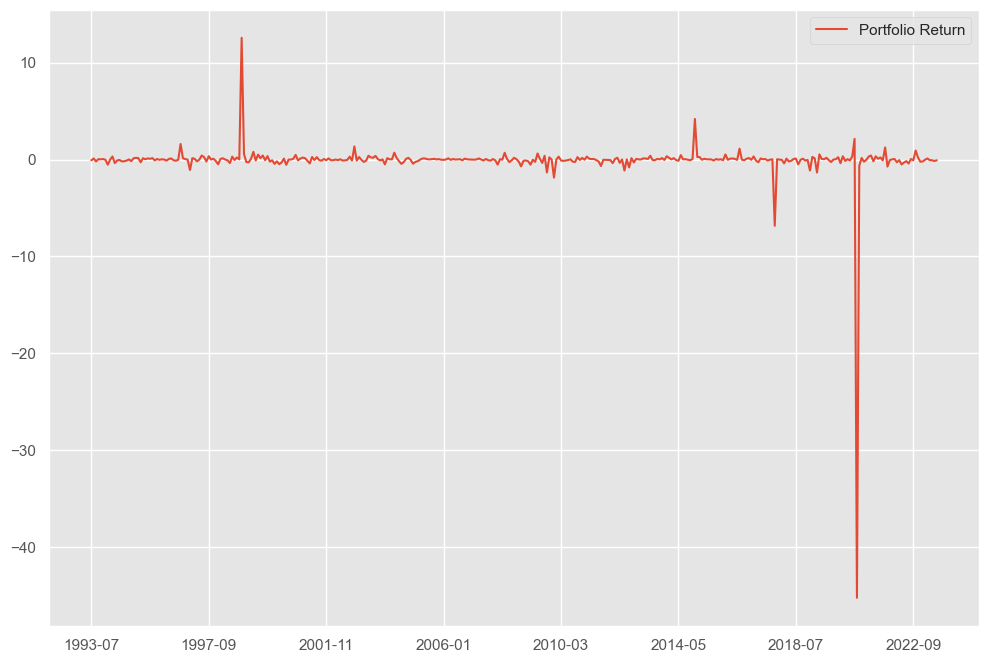

In [320]:
portfolio_return_trailing.plot()

In [321]:
# trailing 6, simple view and simple confidence

weights_trailing, portfolio_return_trailing = trailing_bl_portfolio(start='1993-01', end='2023-07', window=6, 
                                                                    adjustment=[1,3], views=views_simple, confidence=confidence_simple)

In [322]:
(portfolio_return_trailing + 1).cumprod()

,Portfolio Return
1993-07,0.989604
1993-08,0.975321
1993-09,0.935998
1993-10,1.031515
1993-11,1.044365
...,...
2023-03,0.000947
2023-04,0.001079
2023-05,0.000874
2023-06,0.000994


<Axes: >

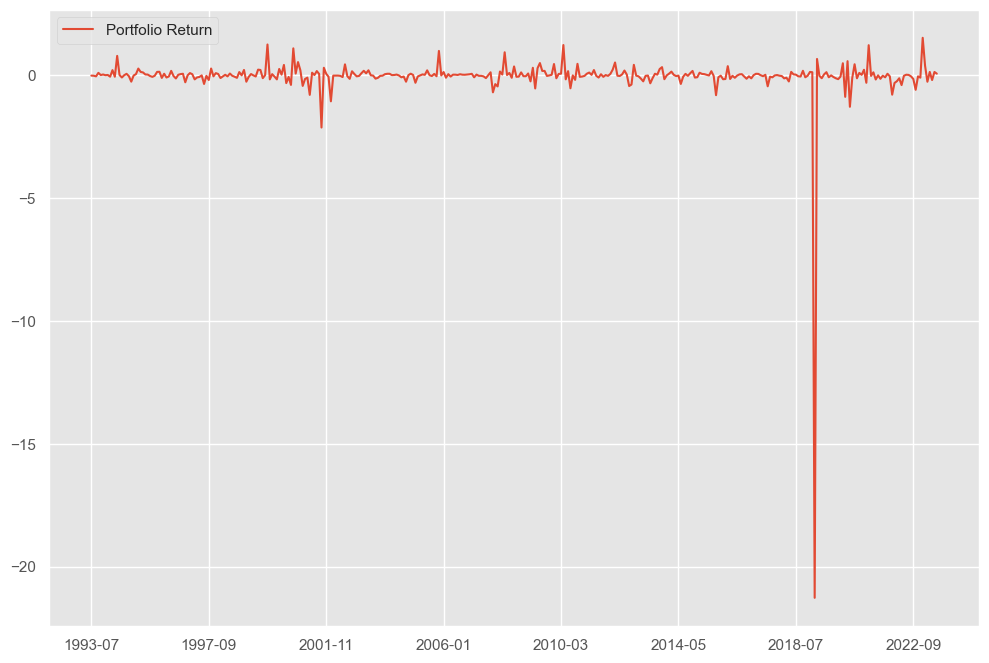

In [323]:
portfolio_return_trailing.plot()

In [324]:
# trailing 24, simple view and simple confidence

weights_trailing, portfolio_return_trailing = trailing_bl_portfolio(start='1991-07', end='2023-07', window=24, 
                                                                    adjustment=[1,3], views=views_simple, confidence=confidence_simple)

In [325]:
(portfolio_return_trailing + 1).cumprod()

,Portfolio Return
1993-07,0.881526
1993-08,0.849358
1993-09,0.842227
1993-10,0.730644
1993-11,0.734721
...,...
2023-03,0.000861
2023-04,0.000828
2023-05,0.000779
2023-06,0.000977


<Axes: >

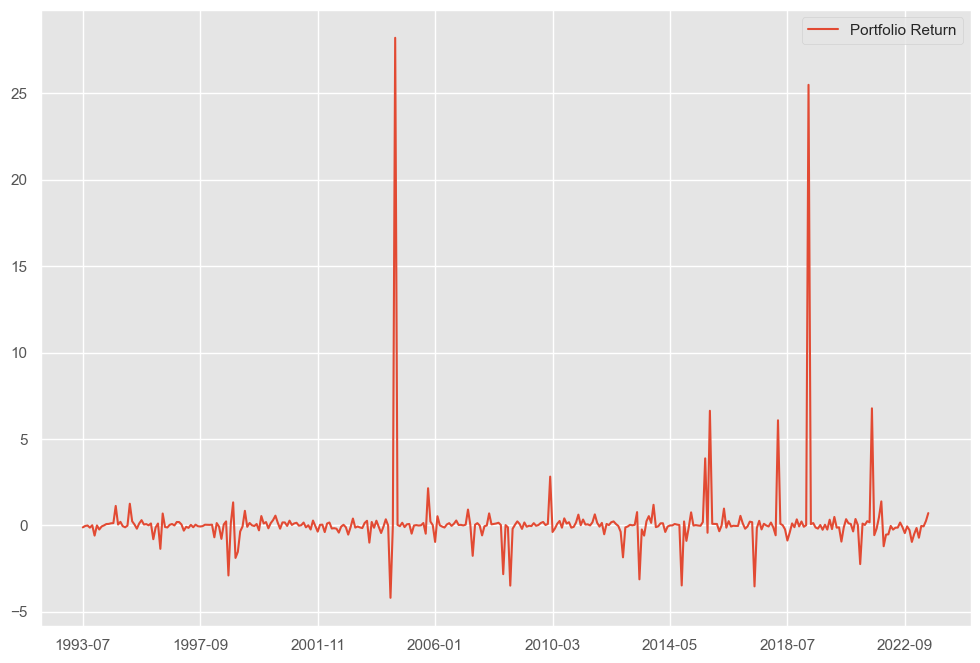

In [326]:
portfolio_return_trailing.plot()

In [327]:
# trailing 12, simple view and simple confidence, broader range of risk aversion

weights_trailing, portfolio_return_trailing = trailing_bl_portfolio(start='1992-07', end='2023-07', window=12, 
                                                                    adjustment=[0.01,10], views=views_simple, confidence=confidence_simple)

In [328]:
(portfolio_return_trailing + 1).cumprod()

,Portfolio Return
1993-07,0.954188
1993-08,1.268976
1993-09,1.254431
1993-10,1.275522
1993-11,1.510282
...,...
2023-03,103.418841
2023-04,104.533815
2023-05,173.070616
2023-06,196.676644


<Axes: >

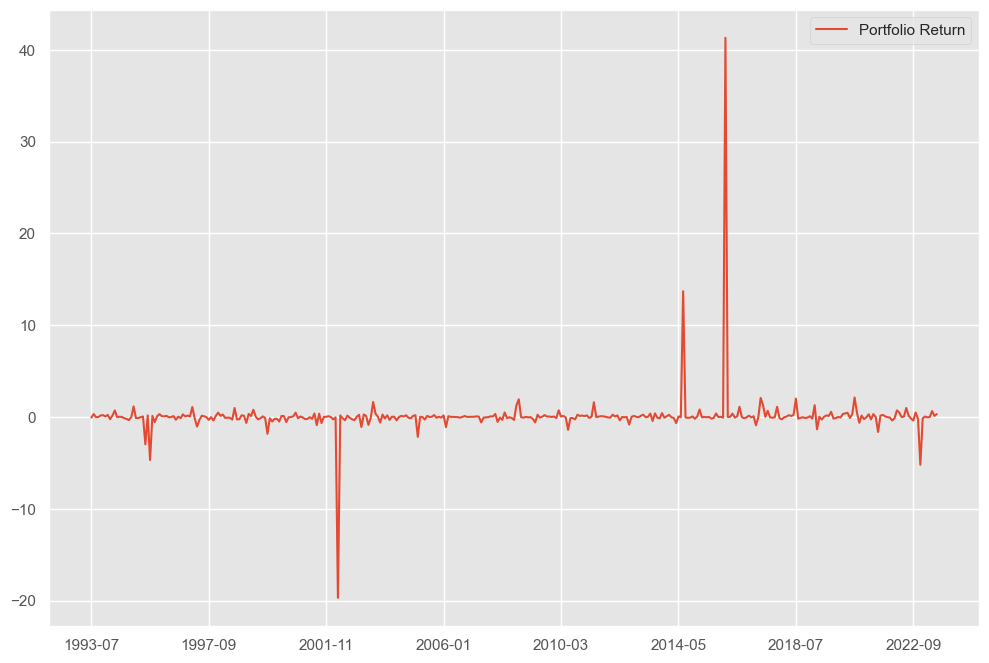

In [329]:
portfolio_return_trailing.plot()

### Hyperparameter Selection

In [379]:
def cumulative_return(ret):
    return (ret + 1).cumprod().iloc[-1].values[0]

In [448]:
def sharpe_ratio(r, riskfree_rate=kit.get_risk_free_rate()['1993-07':'2023-07']['RF'].values.mean(), periods_per_year=12):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    excess_ret = r['Portfolio Return'].values.mean() - riskfree_rate
    vol = r['Portfolio Return'].values.std()
    return excess_ret/vol * np.sqrt(periods_per_year)

In [464]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return drawdowns.min().values[0]

In [408]:
window_choices = [6, 12, 18, 24, 30, 36]
adjustment_choices = [[1, 3], [0.2, 10]]
view_choices = [views_simple, views_weighted]
omega_method_choices = ['idzorek', 'default']
determining_metrics = [cumulative_return, sharpe_ratio, drawdown]
combinations = list(itertools.product(window_choices, adjustment_choices, view_choices, omega_method_choices))
number = len(combinations)

In [353]:
start_dates_mapping = {6: '1993-01', 12: '1992-07', 18: '1992-01', 24: '1991-07', 30: '1991-01', 36: '1990-07'}

In [356]:
def best_param_selector_helper(window_choice, adjustment_choice, view_choice, omega_method_choice, determining_metric):
    weights_trailing, portfolio_return_trailing = trailing_bl_portfolio(start=start_dates_mapping[window_choice], end='2023-07', window=window_choice, adjustment=adjustment_choice, views=view_choice, confidence=confidence_simple, omega_method=omega_method_choice)
    return determining_metric(portfolio_return_trailing)

In [380]:
cumulative_return_params_dict = {str(i): best_param_selector_helper(combinations[i][0], combinations[i][1], combinations[i][2], combinations[i][3], cumulative_return) for i in range(0, 48)}

In [388]:
print("The maximum cumulative return is ", max(cumulative_return_params_dict.values()))

The maximum cumulative return is  1425984.055890127


In [389]:
print("The index of maximum cumulative return is ", max(cumulative_return_params_dict, key=cumulative_return_params_dict.get))

The index of maximum cumulative return is  25


In [450]:
sharpe_ratio_params_dict = {str(i): best_param_selector_helper(combinations[i][0], combinations[i][1], combinations[i][2], combinations[i][3], sharpe_ratio) for i in range(0, 48)}

In [452]:
print("The highest sharpe ratio is ", max(sharpe_ratio_params_dict.values()))

The highest sharpe ratio is  0.28303398724227813


In [453]:
print("The index of highest sharpe ratio is ", max(sharpe_ratio_params_dict, key=sharpe_ratio_params_dict.get))

The index of highest sharpe ratio is  25


In [465]:
drawdown_params_dict = {str(i): best_param_selector_helper(combinations[i][0], combinations[i][1], combinations[i][2], combinations[i][3], drawdown) for i in range(0, 48)}


In [467]:
print("The smallest max drawdown is ", max(drawdown_params_dict.values()))

The smallest max drawdown is  -0.9160363214850457


In [468]:
print("The index of smallest max drawdown is ", max(drawdown_params_dict, key=drawdown_params_dict.get))

The index of smallest max drawdown is  45


#### Visualization on Best Hyperparameter Models

In [470]:
combinations[25]

(24,
 [1, 3],
              Food      Beer     Smoke     Games     Books     Hshld     Clths  \
 1993-07  0.014638  0.016502  0.016637  0.013713  0.010288  0.009990  0.013303   
 1993-08  0.006092 -0.009949  0.009247  0.014631 -0.005595  0.006921  0.010848   
 1993-09  0.018102  0.021639  0.013309  0.012048  0.015149  0.011756  0.015725   
 1993-10  0.014599  0.018517  0.016293  0.014407  0.024278  0.010692  0.010667   
 1993-11  0.033829 -0.010025  0.048741  0.018381  0.035024  0.008435  0.012796   
 ...           ...       ...       ...       ...       ...       ...       ...   
 2023-03  0.012558  0.008428 -0.022145 -0.020055  0.009410  0.011965  0.012969   
 2023-04  0.004687  0.009118  0.014818  0.012069  0.002305  0.010008  0.013102   
 2023-05  0.004707  0.011196  0.004127  0.011945 -0.002513  0.009828  0.011364   
 2023-06  0.009908  0.007937  0.053411  0.016609 -0.001666 -0.008361 -0.024122   
 2023-07  0.004412  0.007949  0.017594  0.011627 -0.002194 -0.007418  0.054194   
 


In [472]:
# Max cum_return and sharpe ratio
weights_trailing25, portfolio_return_trailing25 = trailing_bl_portfolio(start=start_dates_mapping[combinations[25][0]], end='2023-07', 
                                                                        window=combinations[25][0], adjustment=combinations[25][1], 
                                                                        views=combinations[25][2], confidence=confidence_simple, 
                                                                        omega_method=combinations[25][3])

In [474]:
portfolio_return_trailing25

,Portfolio Return
1993-07,0.160822
1993-08,-0.004034
1993-09,0.018637
1993-10,0.086604
1993-11,0.064903
...,...
2023-03,0.012179
2023-04,0.083566
2023-05,-0.275795
2023-06,0.569766


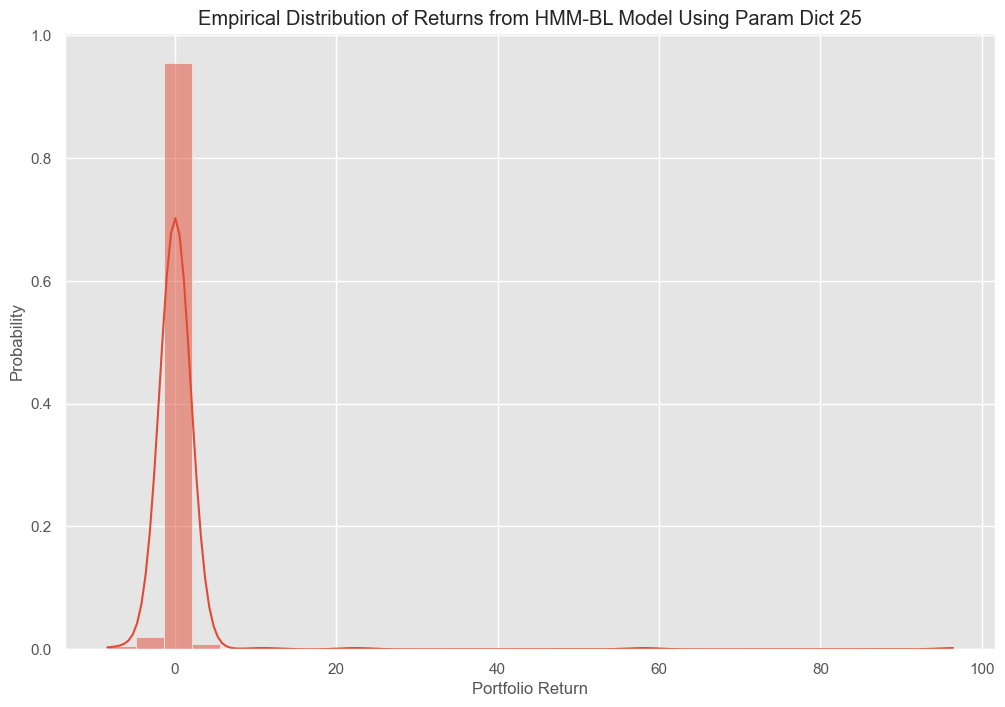

In [480]:
sns.histplot(portfolio_return_trailing25, x='Portfolio Return', bins=30, stat='probability', kde=True)
plt.title('Empirical Distribution of Returns from HMM-BL Model Using Param Dict 25');

In [482]:
(portfolio_return_trailing25 + 1).cumprod()

,Portfolio Return
1993-07,1.160822
1993-08,1.156139
1993-09,1.177686
1993-10,1.279679
1993-11,1.362734
...,...
2023-03,665864.962679
2023-04,721508.802088
2023-05,522520.382752
2023-06,820234.947913


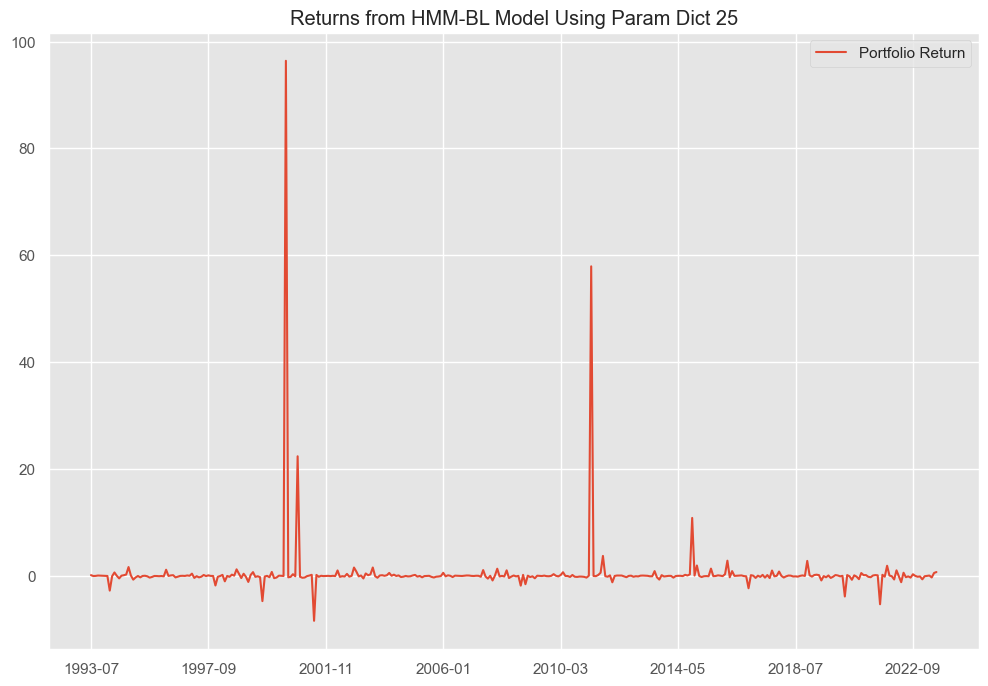

In [487]:
portfolio_return_trailing25.plot()
plt.title('Returns from HMM-BL Model Using Param Dict 25');

TODO: Calculate the value weighted portfolio original winrate and sharpe ratio.

In [502]:
def winrate(ret):
    return ret[ret['Portfolio Return'].values > 0].shape[0] / ret.shape[0]

In [504]:
print("The win rate of Param Dict 25 is ", winrate(portfolio_return_trailing25))

The win rate of Param Dict 25 is  0.5346260387811634


In [510]:
print("The mean of Param Dict 25 return is ", portfolio_return_trailing25.mean())

The mean of Param Dict 25 return is  Portfolio Return    0.500009
dtype: object


In [511]:
print("The standard deviation of Param Dict 25 return is ", portfolio_return_trailing25.std())

The standard deviation of Param Dict 25 return is  Portfolio Return    6.1054
dtype: object


In [484]:
combinations[45]

(36,
 [0.2, 10],
              Food      Beer     Smoke     Games     Books     Hshld     Clths  \
 1993-07  0.014638  0.016502  0.016637  0.013713  0.010288  0.009990  0.013303   
 1993-08  0.006092 -0.009949  0.009247  0.014631 -0.005595  0.006921  0.010848   
 1993-09  0.018102  0.021639  0.013309  0.012048  0.015149  0.011756  0.015725   
 1993-10  0.014599  0.018517  0.016293  0.014407  0.024278  0.010692  0.010667   
 1993-11  0.033829 -0.010025  0.048741  0.018381  0.035024  0.008435  0.012796   
 ...           ...       ...       ...       ...       ...       ...       ...   
 2023-03  0.012558  0.008428 -0.022145 -0.020055  0.009410  0.011965  0.012969   
 2023-04  0.004687  0.009118  0.014818  0.012069  0.002305  0.010008  0.013102   
 2023-05  0.004707  0.011196  0.004127  0.011945 -0.002513  0.009828  0.011364   
 2023-06  0.009908  0.007937  0.053411  0.016609 -0.001666 -0.008361 -0.024122   
 2023-07  0.004412  0.007949  0.017594  0.011627 -0.002194 -0.007418  0.054194   

In [473]:
# Min Max-Drawdown 
weights_trailing45, portfolio_return_trailing45 = trailing_bl_portfolio(start=start_dates_mapping[combinations[45][0]], end='2023-07', 
                                                                        window=combinations[45][0], adjustment=combinations[45][1], 
                                                                        views=combinations[45][2], confidence=confidence_simple, 
                                                                        omega_method=combinations[45][3])

In [485]:
portfolio_return_trailing45

,Portfolio Return
1993-07,-0.010956
1993-08,-0.041103
1993-09,-0.020791
1993-10,-0.154565
1993-11,0.052035
...,...
2023-03,0.119109
2023-04,0.070443
2023-05,-0.047153
2023-06,0.1533


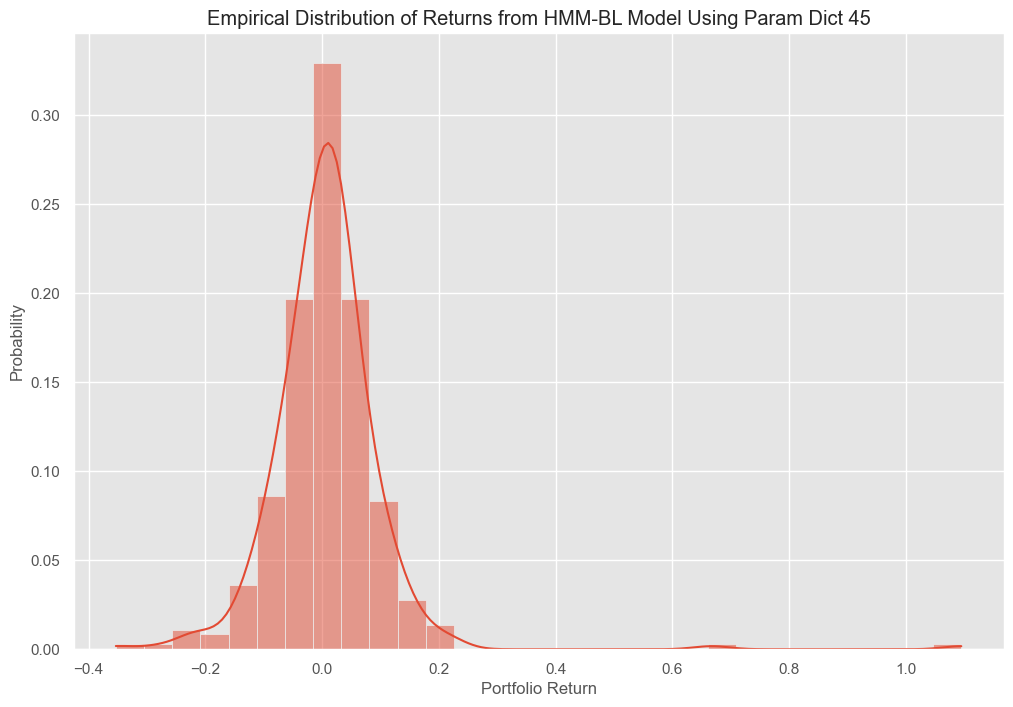

In [486]:
sns.histplot(portfolio_return_trailing45, x='Portfolio Return', bins=30, stat='probability', kde=True)
plt.title('Empirical Distribution of Returns from HMM-BL Model Using Param Dict 45');

In [488]:
(portfolio_return_trailing45 + 1).cumprod()

,Portfolio Return
1993-07,0.989044
1993-08,0.948392
1993-09,0.928674
1993-10,0.785134
1993-11,0.825988
...,...
2023-03,2.447183
2023-04,2.61957
2023-05,2.496048
2023-06,2.878692


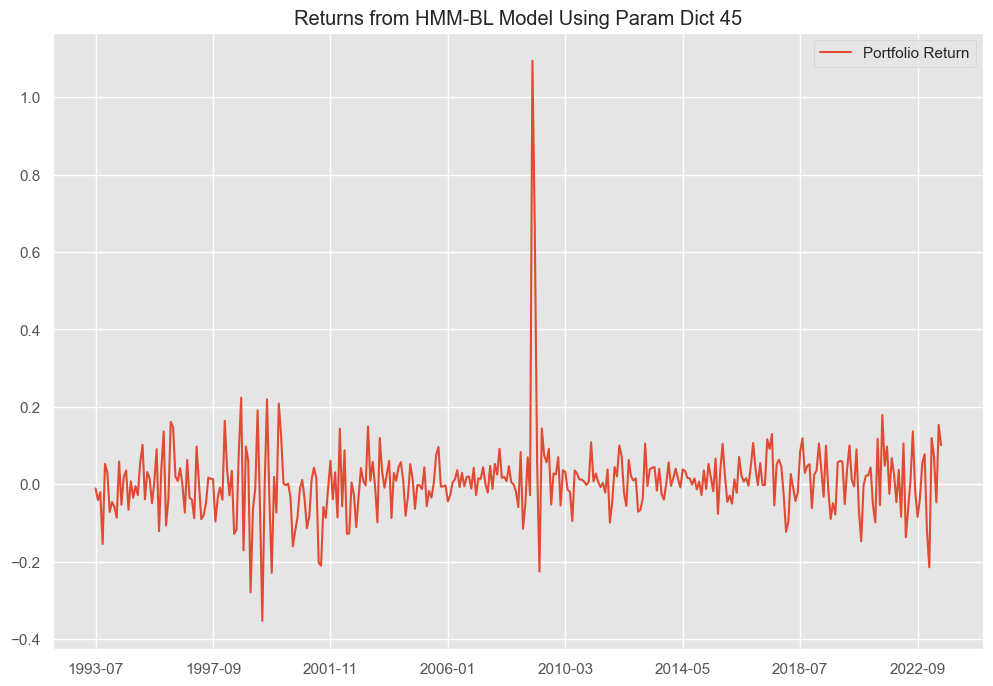

In [489]:
portfolio_return_trailing45.plot()
plt.title('Returns from HMM-BL Model Using Param Dict 45');

In [505]:
print("The win rate of Param Dict 45 is ", winrate(portfolio_return_trailing45))

The win rate of Param Dict 45 is  0.5457063711911357


In [506]:
print("The mean of Param Dict 45 return is ", portfolio_return_trailing45.mean())

The mean of Param Dict 45 return is  Portfolio Return    0.007493
dtype: object


In [508]:
print("The standard deviation of Param Dict 45 return is ", portfolio_return_trailing45.std())

The standard deviation of Param Dict 45 return is  Portfolio Return    0.100418
dtype: object


## Summary Statistics

In [515]:
port_returns = [trailing_bl_portfolio(start=start_dates_mapping[combinations[i][0]], end='2023-07', 
                                                                        window=combinations[i][0], adjustment=combinations[i][1], 
                                                                        views=combinations[i][2], confidence=confidence_simple, 
                                                                        omega_method=combinations[i][3])[1] for i in range(48)]

Recognized recessions during the period in interest are 2001-2002 (dot-com bubble), 2007-2009 (subprime mortgage crisis), and 2020-2021 (economic effects of the pandemic).

In [527]:
start_date1 = pd.to_datetime('2001-01')
end_date1 = pd.to_datetime('2002-12')
start_date2 = pd.to_datetime('2007-01')
end_date2 = pd.to_datetime('2009-12')
start_date3 = pd.to_datetime('2020-01')
end_date3 = pd.to_datetime('2021-12')

In [537]:
periods = [(pd.to_datetime('2001-01'), pd.to_datetime('2002-12')),
           (pd.to_datetime('2007-01'), pd.to_datetime('2009-12')),
           (pd.to_datetime('2020-01'), pd.to_datetime('2021-12'))]

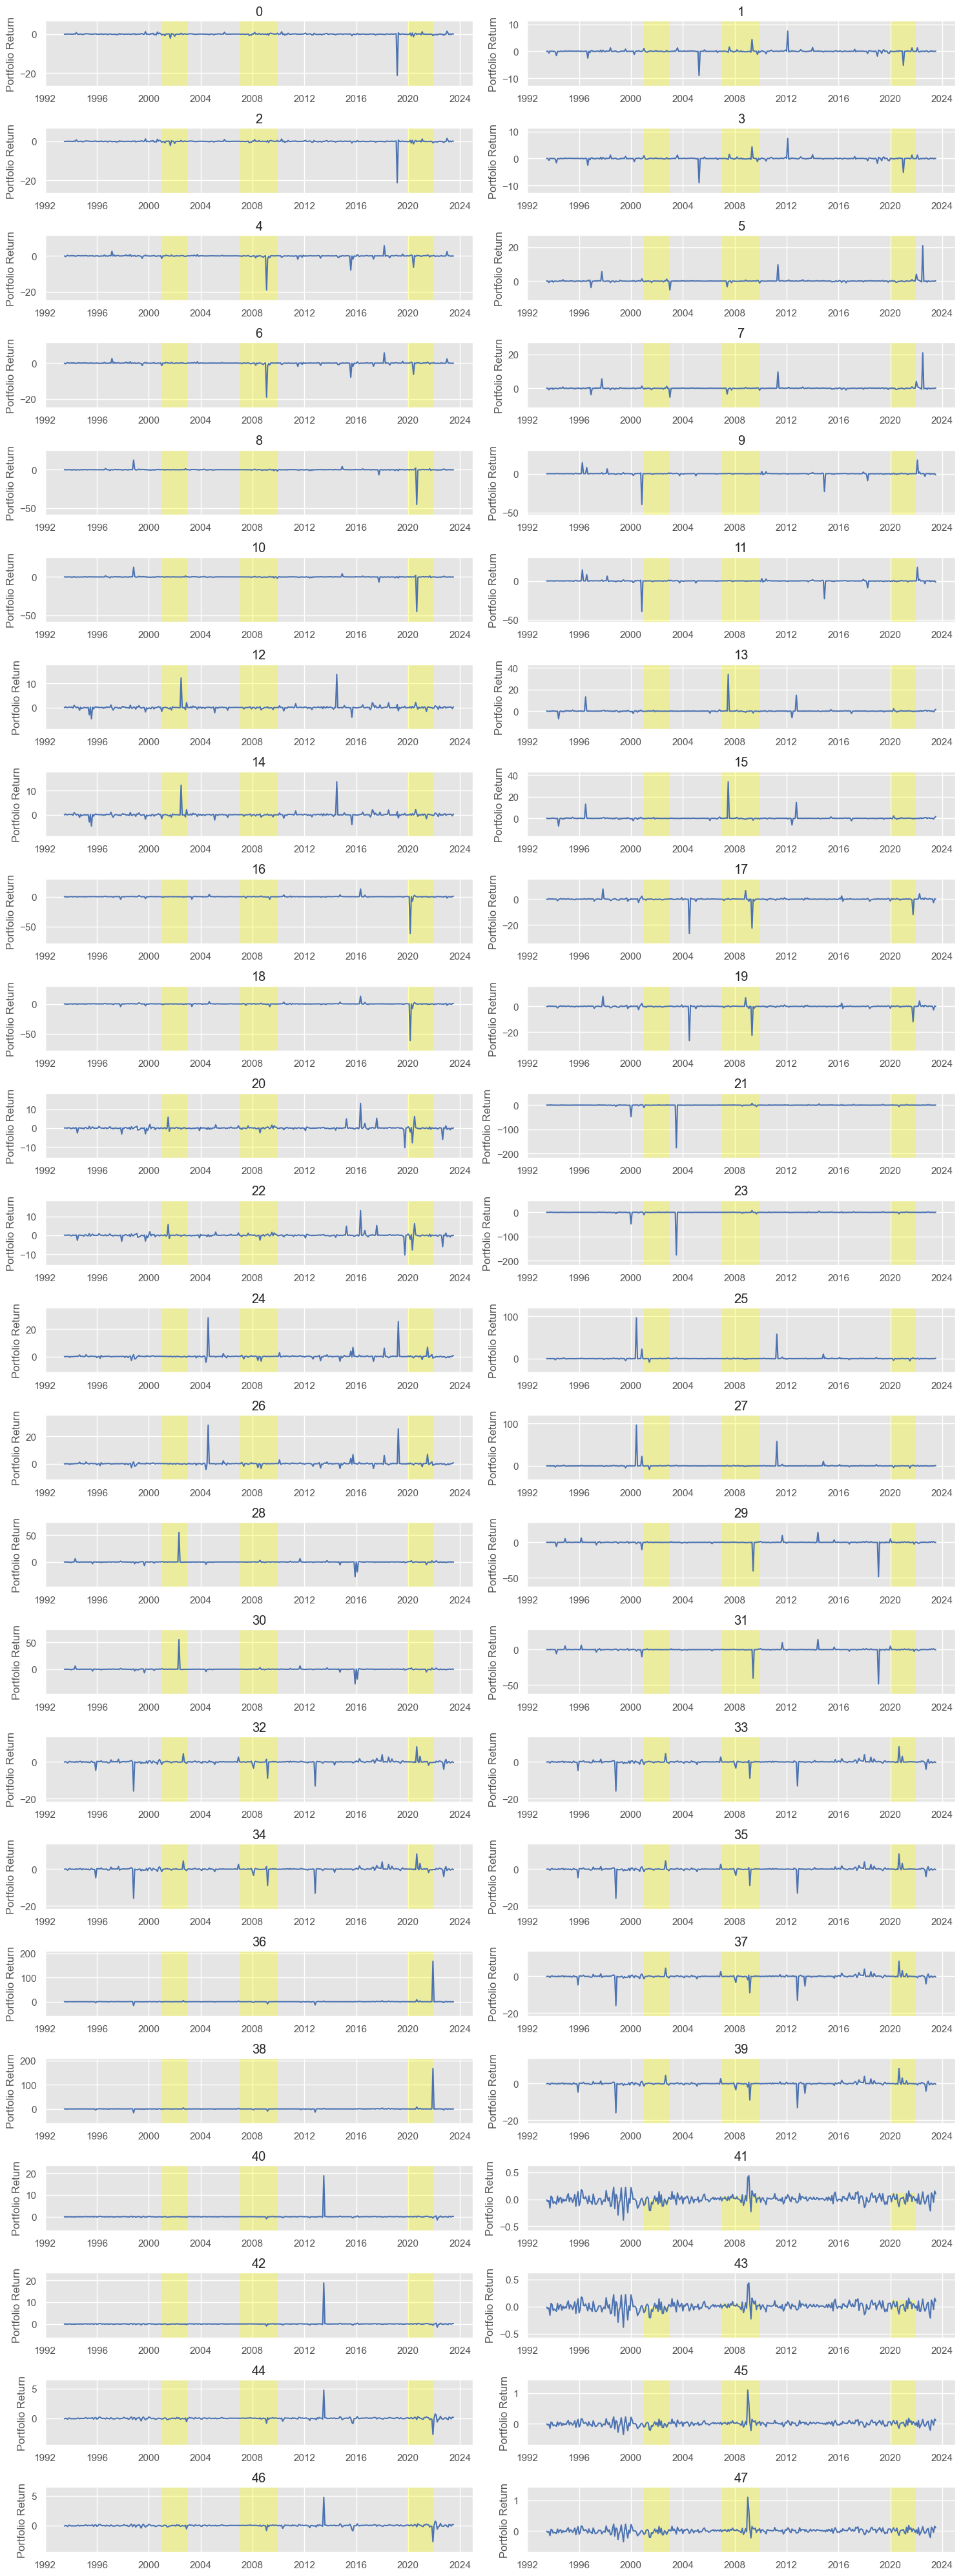

In [539]:
fig, axes = plt.subplots(24, 2, figsize=(15, 40))  
axes = axes.flatten()


for i in range(len(port_returns)):
    ret = port_returns[i]
    ret.index = pd.to_datetime(ret.index)

    sns.lineplot(ret, x=ret.index, y='Portfolio Return', ax=axes[i], color='b')
    for start_date, end_date in periods:
        axes[i].fill_between(ret.index, axes[i].get_ylim()[0], axes[i].get_ylim()[1], 
                            where=(ret.index >= start_date) & (ret.index <= end_date), 
                            color='yellow', alpha=0.3, transform=axes[i].get_xaxis_transform())
    axes[i].set_title(i)


plt.tight_layout()
plt.show()

We observe most of the returns spikes around the turbulent periods of economonic cycle. This indicate the HMM-BL model is able to capture market hidden trend or switch in regime with some false positives. The result inspires me to discover Thompson sampling for online portfolio selection that completes the entire portfolio  selection and management process.

In [544]:
ind_rets = kit.get_ind_returns(weighting="vw", n_inds=30)["1991-07":"2023-07"]
ind_mcap = kit.get_ind_market_caps(30, weights=True)["1991-07":"2023-07"]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.106601,0.162358,-0.579022,5.222279,0.072708,0.107494,0.459009,-0.530866
CW,0.104615,0.155571,-0.615573,4.323060,0.070754,0.101158,0.466625,-0.518908
GMV-Sample,0.067746,0.127957,-0.630900,4.196721,0.059956,0.082980,0.286949,-0.421907
HMM_BL25,0.601655,21.149726,13.224382,191.903309,-56.660636,2.166668,0.023426,-281.926618


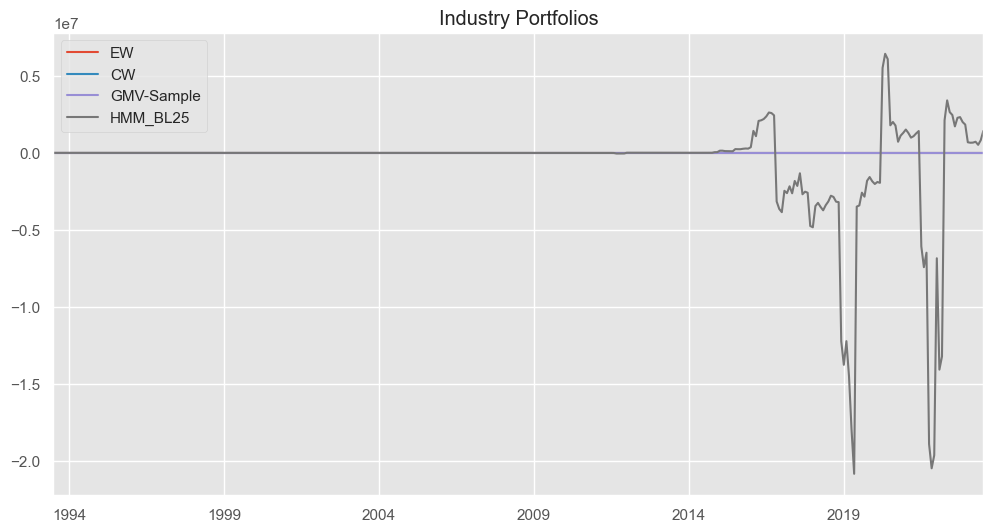

In [545]:
ewr = kit.backtest_ws(ind_rets, estimation_window=24, weighting=kit.weight_ew).dropna()
cwr = kit.backtest_ws(ind_rets, estimation_window=24, weighting=kit.weight_cw, cap_weights=ind_mcap).dropna()
mv_s_r = kit.backtest_ws(ind_rets, estimation_window=24, weighting=kit.weight_gmv, cov_estimator=kit.sample_cov).dropna()
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, 'HMM_BL25': port_returns[25]['Portfolio Return'].values})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
kit.summary_stats(btr.dropna())

We observe the HMM_BL model has the highest return, but also higher volatility and risk measurements in general. Let's try to set some constraints on the weights.

# Further Implications and Extensions

The Black-Litterman model is a widely used approach in portfolio optimization. It combines the ideas from the Capital Asset Pricing Model (CAPM) and the Mean-Variance Optimization model and integrates the investor's views into the portfolio construction process. Since its introduction, several extensions and modifications have been proposed to address various limitations and adapt it to different investment contexts. Some notable extensions include:

1. **Bayesian Approach**: This extension incorporates Bayesian methods to update the expected returns based on the investor's views, allowing for a more dynamic and probabilistic approach to incorporating subjective views.

2. **Global Views**: This involves extending the model to handle global asset allocation problems, where assets are spread across multiple countries and asset classes.

3. **Incorporating Transaction Costs**: Some extensions focus on integrating transaction costs into the model, making it more applicable to real-world scenarios where buying and selling assets incurs costs.

4. **Robust Optimization**: Modifications that include robust optimization techniques aim to make the model more resistant to errors in the input data, such as estimated returns, covariances, and market capitalizations.

5. **Factor Models**: Integrating factor-based approaches (like Fama-French factors) with the Black-Litterman model to better capture the sources of risk and return in the portfolio.

6. **Machine Learning Techniques**: Recent developments have seen the incorporation of machine learning algorithms to estimate the input parameters more accurately, especially in the context of big data and complex market dynamics.

7. **Risk Parity and Alternative Risk Measures**: Some extensions focus on incorporating alternative risk measures like Conditional Value at Risk (CVaR) or applying risk parity concepts within the Black-Litterman framework.

8. **ESG Integration**: Adapting the model to include Environmental, Social, and Governance (ESG) factors, which is increasingly relevant for socially responsible investing.

9. **High-Dimensional Data Handling**: Enhancements for better handling high-dimensional data sets, addressing issues like overfitting and estimation error magnification in traditional models.

10. **Liquidity Adjustment**: Adjusting the model to account for the liquidity of different assets, which is crucial for large portfolios where significant transactions can impact market prices.

These extensions and modifications are part of ongoing efforts to make the Black-Litterman model more adaptable to the changing financial landscape and the diverse needs of investors. They reflect the continuous evolution of portfolio optimization theory as it integrates more sophisticated risk management techniques, new types of data, and advanced computational methods.

In [550]:
# port_returns[25].to_csv('../Data/HMM-BL25.csv')

In [551]:
# port_returns[45].to_csv('../Data/HMM-BL45.csv')